# GO Analysis for WGCNA
## Phase 1

Gene ontology of modules from [WGCNA](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase1_v_phase1/wgcna/wgcna_p1.ipynb). Following [Gurr code](https://github.com/SamGurr/Pgenerosa_OA_TagSeq/blob/main/TagSeq/Analysis/Scripts/GO_Analysis_WGCNA_all.R)

Since we don't have log fold change (because we aren't looking at differential expression), we can only do an over-representation analysis (ORA) - provide a gene list of interest (genes in a significantly correlated module) and a universal gene list (after filtering for wgcna - so *not* all genes in the CV genome, but rather what went in as input to wgcna)

## 0. load libraries

In [2]:
library(tidyverse)
library(goseq)
library(reshape2)
library(Rmisc)
library(ggpubr)
library(gridExtra)
library(forcats)
library(zoo)
library(ComplexHeatmap)
library(GO.db)
library(GSEABase)
library(clusterProfiler)

## 1. load data
WGCNA module membership, module colors, and goslim_generic.obo

#### A. gene annotation to GO.term - long format
matches GO terms to *C. virginica* genes - one GO term per row (so genes are duplicated among rows)

In [18]:
annot <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
colnames(annot)[1] <- 'Gene'
colnames(annot)[2] <- 'GO.terms'

# One row for each gene and GO.term
term2gene <- annot %>%
  separate_rows(GO.terms, sep = "; ") %>% # one row for each GO.term
  filter(!is.na(GO.terms) & GO.terms != "") %>% # remove genes without GO terms
  dplyr::select(term = GO.terms, gene = Gene) # rename columns for GO 

head(term2gene)

term,gene
<chr>,<chr>
GO:0005042,LOC111126949
GO:0005737,LOC111126949
GO:0008233,LOC111126949
GO:0016020,LOC111126949
GO:0043123,LOC111126949
GO:0046330,LOC111126949


this becomes input for `enricher` down below

get term names for GO IDs

In [23]:
# Extract GO term descriptions
go_terms <- unique(term2gene$term)

# Get descriptions from GO.db
term2name <- data.frame(
  term = go_terms,
  name = sapply(go_terms, function(x) {
    tryCatch({
      Term(GOTERM[[x]])
    }, error = function(e) {
      NA_character_
    })
  })
)

# Remove NAs
term2name <- term2name[!is.na(term2name$name), ]

# View
head(term2name)    

,term,name
,<chr>,<chr>
GO:0005042,GO:0005042,netrin receptor activity
GO:0005737,GO:0005737,cytoplasm
GO:0008233,GO:0008233,peptidase activity
GO:0016020,GO:0016020,membrane
GO:0043123,GO:0043123,positive regulation of canonical NF-kappaB signal transduction
GO:0046330,GO:0046330,positive regulation of JNK cascade


#### B. GOslim data

GO Slim - higher level of GO used to summarize GO results into broader categories (the parent terms)

In [5]:
slim <- getOBOCollection("http://current.geneontology.org/ontology/subsets/goslim_generic.obo")
class(slim)

[1] "OBOCollection"
attr(,"package")
[1] "GSEABase"

In [6]:
# 1. Get the GO IDs
slim_ids <- ids(slim)

# 2. Get the IDs that belong to the generic subset
slim_ids <- ids(slim["goslim_generic" ])

# 3. Get the terms for those specific IDs
# use the GO.db package because it's much faster and more reliable for names
slim_terms <- Term(slim_ids)

# 4. Create lookup table 
slim_lookup <- data.frame(
  SlimID = names(slim_terms), # parent ID
  GOSlim_Bin = as.character(slim_terms), # biological term
  stringsAsFactors = FALSE
)

head(slim_lookup)

,SlimID,GOSlim_Bin
,<chr>,<chr>
1,GO:0000228,nuclear chromosome
2,GO:0000278,mitotic cell cycle
3,GO:0000910,cytokinesis
4,GO:0001618,virus receptor activity
5,GO:0002181,cytoplasmic translation
6,GO:0002376,immune system process


this table can be used to assign GO terms to broader categories - however, this table only contains parent terms (SlimID), so cannot directly be merged with GO results - need to match the parent terms to the GO IDs

In [7]:
# 1. Get a list of all ancestors for every GO term in WGCNA results
# This creates a mapping of Specific_ID -> All_Ancestors
all_ancestors <- as.list(GOBPANCESTOR)

# lookup vector - parent GO terms
target_slim_ids <- unique(slim_lookup$SlimID)

# 2. make lookup function
find_slim_parent <- function(specific_id, slim_ids) {
  if (is.na(specific_id)) return(NA_character_) # if GO term isn't in ancestor lookup
  if (specific_id %in% slim_ids) return(specific_id) # if GO term is the parent term
  
  # Get ancestors from the GO.db object
  ancestors <- all_ancestors[[specific_id]]
  
  if (is.null(ancestors)) return(NA_character_) # if no ancestor term
  
  # Find which ancestors are in your Slim list
  match <- intersect(ancestors, slim_ids)
  
  if (length(match) == 0) return(NA_character_)
  return(as.character(match[1])) 
}


#### C. Gene info
read in gene info from [wgcna_p1.ipynb](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase1_v_phase1/wgcna/wgcna_p1.ipynb)

contains the gene name, matching GO terms, module color, gene significance (GS) for every treatment, and module membership (MM) for each module

In [8]:
geneInfo <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/wgcna/p1.wgcna_GeneInfo.csv') 
head(geneInfo) 

,Gene,GO.terms,ModuleColor,phase1_temp.GS.warm,phase1_temp.GS.ambient,phase1_DO.GS.hypoxic,phase1_DO.GS.normoxic,phase1_treatment.GS.both,phase1_treatment.GS.control,phase1_treatment.GS.hypoxic,⋯,MMdarkgreen,MMturquoise,MMblack,MMtan,MMlightgreen,MMlightcyan,MMdarkorange,MMgreenyellow,MMdarkred,MMwhite
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,COX2,GO:0004129; GO:0005507; GO:0005743; GO:0070469,cyan,-0.2002618,0.2002618,-0.10177922,0.10177922,-0.32960471,0.03398997,0.1938264,⋯,0.24247876,0.3764425,0.05708880,-0.121567508,-0.05321238,-0.3373683,-0.47785434,-0.5968790,0.06015678,-0.1030147
2,COX3,GO:0004129; GO:0005743; GO:0008535; GO:0019646; GO:0045277,cyan,0.1848033,-0.1848033,-0.17549766,0.17549766,-0.07944662,-0.08521314,-0.1250178,⋯,0.38116885,0.2699948,-0.03282921,-0.129676056,-0.33864040,-0.2506377,-0.36530759,-0.7762514,-0.05646699,-0.2144529
3,CYTB,GO:0005743; GO:0008121; GO:0022904; GO:0045275; GO:0046872,cyan,0.1884373,-0.1884373,-0.20204711,0.20204711,-0.10256367,-0.08085939,-0.1335056,⋯,0.22572587,0.2518677,-0.36272854,0.002679583,-0.30850184,-0.4185898,-0.29518001,-0.4936426,-0.27020281,-0.4346506
4,LOC111099029,GO:0005886; GO:0015280; GO:0035725; GO:0046872; GO:0047631; GO:0070588; GO:0099604,black,0.3225767,-0.3225767,-0.06852276,0.06852276,0.05792194,-0.23460183,-0.1323592,⋯,0.08759165,0.1747921,0.44911899,0.003606062,-0.16056103,-0.2867158,-0.08276099,0.0335708,-0.11062113,-0.2394900
5,LOC111099033,GO:0005737; GO:0005886; GO:0005903; GO:0006814; GO:0007420; GO:0008520; GO:0009636; GO:0009925; GO:0015081; GO:0015229; GO:0015882; GO:0016324; GO:0030324; GO:0033300; GO:0043229; GO:0070837,red,-0.3134304,0.3134304,0.26699623,-0.26699623,0.15785413,0.20110134,0.1554549,⋯,-0.22296840,-0.3011792,-0.14939005,-0.139349907,0.03712205,-0.2972232,-0.23745683,0.3801969,0.13237636,-0.2259500
6,LOC111099035,GO:0004090; GO:0005739; GO:0005743; GO:0005783; GO:0016616; GO:0047045,red,-0.3294223,0.3294223,0.17025855,-0.17025855,0.05569421,0.23337912,0.1413693,⋯,0.04291840,-0.3019077,-0.28587246,0.070902666,0.54734007,0.3996460,0.10179595,0.2854629,0.20741010,0.2788549


categorize gene info columns

In [9]:
# Get all column names once
all_cols <- names(geneInfo)

# 1. The 16 'Combo_treatments.GS' columns
combo_cols <- grep("^Combo_treatments\\.GS\\.", all_cols, value = TRUE)

# 2. Phase 1 & 2 Driver columns (Temp and DO)
p1_driver_cols <- grep("^phase1_(temp|DO)\\.GS\\.", all_cols, value = TRUE)
p2_driver_cols <- grep("^phase2_(temp|DO)\\.GS\\.", all_cols, value = TRUE)

# 3. Overall Phase Treatment columns
p1_overall_cols <- grep("^phase1_treatment\\.GS\\.", all_cols, value = TRUE)
p2_overall_cols <- grep("^phase2_treatment\\.GS\\.", all_cols, value = TRUE)

# 4. Module Membership (MM) colors
mm_cols <- grep("^MM", all_cols, value = TRUE)

#### Module membership
pull out just the genes, associated GO terms, and which module they're been assigned to

In [10]:
moduleMembership <-  geneInfo %>% dplyr::select(Gene, GO.terms, ModuleColor) # select for genes, GO.ids, modules
head(moduleMembership)

,Gene,GO.terms,ModuleColor
,<chr>,<chr>,<chr>
1,COX2,GO:0004129; GO:0005507; GO:0005743; GO:0070469,cyan
2,COX3,GO:0004129; GO:0005743; GO:0008535; GO:0019646; GO:0045277,cyan
3,CYTB,GO:0005743; GO:0008121; GO:0022904; GO:0045275; GO:0046872,cyan
4,LOC111099029,GO:0005886; GO:0015280; GO:0035725; GO:0046872; GO:0047631; GO:0070588; GO:0099604,black
5,LOC111099033,GO:0005737; GO:0005886; GO:0005903; GO:0006814; GO:0007420; GO:0008520; GO:0009636; GO:0009925; GO:0015081; GO:0015229; GO:0015882; GO:0016324; GO:0030324; GO:0033300; GO:0043229; GO:0070837,red
6,LOC111099035,GO:0004090; GO:0005739; GO:0005743; GO:0005783; GO:0016616; GO:0047045,red


#### D. universal list
this is the input gene list for wgcna before module assignment, but after gene filtering

In [11]:
universal_genes <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/wgcna/p1.wgcna_UniversalGeneList.csv')
head(universal_genes)

,gene
,<chr>
1,LOC111126949
2,LOC111120752
3,LOC111105691
4,LOC111133554
5,LOC111113860
6,LOC111109550


## 2. run GO enrichment
over-representation analysis

#### input data:
- universal_genes
- term2gene (matches gene LOC to GO term)
- term2name (matches GO term to GO description)
- geneInfo (output from WGCNA)

slim_lookup for matching parent GO terms to GO results

### pink module
significantly correlated with phase 1 temperature (neg. for warm)

In [24]:
target_genes <- geneInfo %>%
  filter(ModuleColor == "pink") %>%
  pull(Gene)

# Run the custom enrichment
ego_custom <- enricher(gene = target_genes,
                       universe = universal_genes$gene,
                       TERM2NAME = term2name,
                       TERM2GENE = term2gene,
                       pvalueCutoff = 0.05)

# make df
pink_res <- as.data.frame(ego_custom)
head(pink_res)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0016747,GO:0016747,"acyltransferase activity, transferring groups other than amino-acyl groups",8/521,12/12345,4.069351e-09,6.169135e-06,5.628554e-06,LOC111124813/LOC111124814/LOC111125521/LOC111126818/LOC111127409/LOC111137418/LOC111137913/LOC111138175,8
GO:0050953,GO:0050953,sensory perception of light stimulus,6/521,10/12345,9.978394e-07,5.042415e-04,4.600565e-04,LOC111109829/LOC111118033/LOC111118034/LOC111118035/LOC111118036/LOC111121348,6
GO:0050957,GO:0050957,equilibrioception,6/521,10/12345,9.978394e-07,5.042415e-04,4.600565e-04,LOC111109829/LOC111118033/LOC111118034/LOC111118035/LOC111118036/LOC111121348,6
GO:0016339,GO:0016339,calcium-dependent cell-cell adhesion via plasma membrane cell adhesion molecules,6/521,14/12345,1.234138e-05,4.677384e-03,4.267520e-03,LOC111109559/LOC111109829/LOC111118035/LOC111118036/LOC111133568/LOC111133569,6
GO:0016324,GO:0016324,apical plasma membrane,29/521,294/12345,1.885317e-05,5.716282e-03,5.215383e-03,LOC111099154/LOC111099678/LOC111101789/LOC111107140/LOC111108340/LOC111109559/LOC111111564/LOC111113025/LOC111113028/LOC111113029/LOC111115910/LOC111115950/LOC111118314/LOC111120427/LOC111121574/LOC111122499/LOC111124468/LOC111125053/LOC111128640/LOC111131309/LOC111131510/LOC111133528/LOC111134479/LOC111134699/LOC111136297/LOC111136394/LOC111136476/LOC111136612/LOC111138360,29
GO:0060088,GO:0060088,auditory receptor cell stereocilium organization,5/521,10/12345,2.774986e-05,7.011464e-03,6.397073e-03,LOC111109829/LOC111118033/LOC111118034/LOC111118035/LOC111118036,5


look for parent terms/bin GO terms to broader categories

In [25]:
pink_mapped <- pink_res %>%
  # Process each row's ID individually
  rowwise() %>%
  # use function from earlier to map parent term to GO ID
  mutate(SlimID = find_slim_parent(ID, target_slim_ids)) %>% 
  ungroup() %>%
  # Join with lookup table to get 'GOSlim_Bin'
  left_join(slim_lookup, by = "SlimID")

# Remove terms that didn't map to a slim category if desired
pink_final <- pink_mapped %>%
  filter(!is.na(GOSlim_Bin)) %>%
mutate(module = "'pink'")

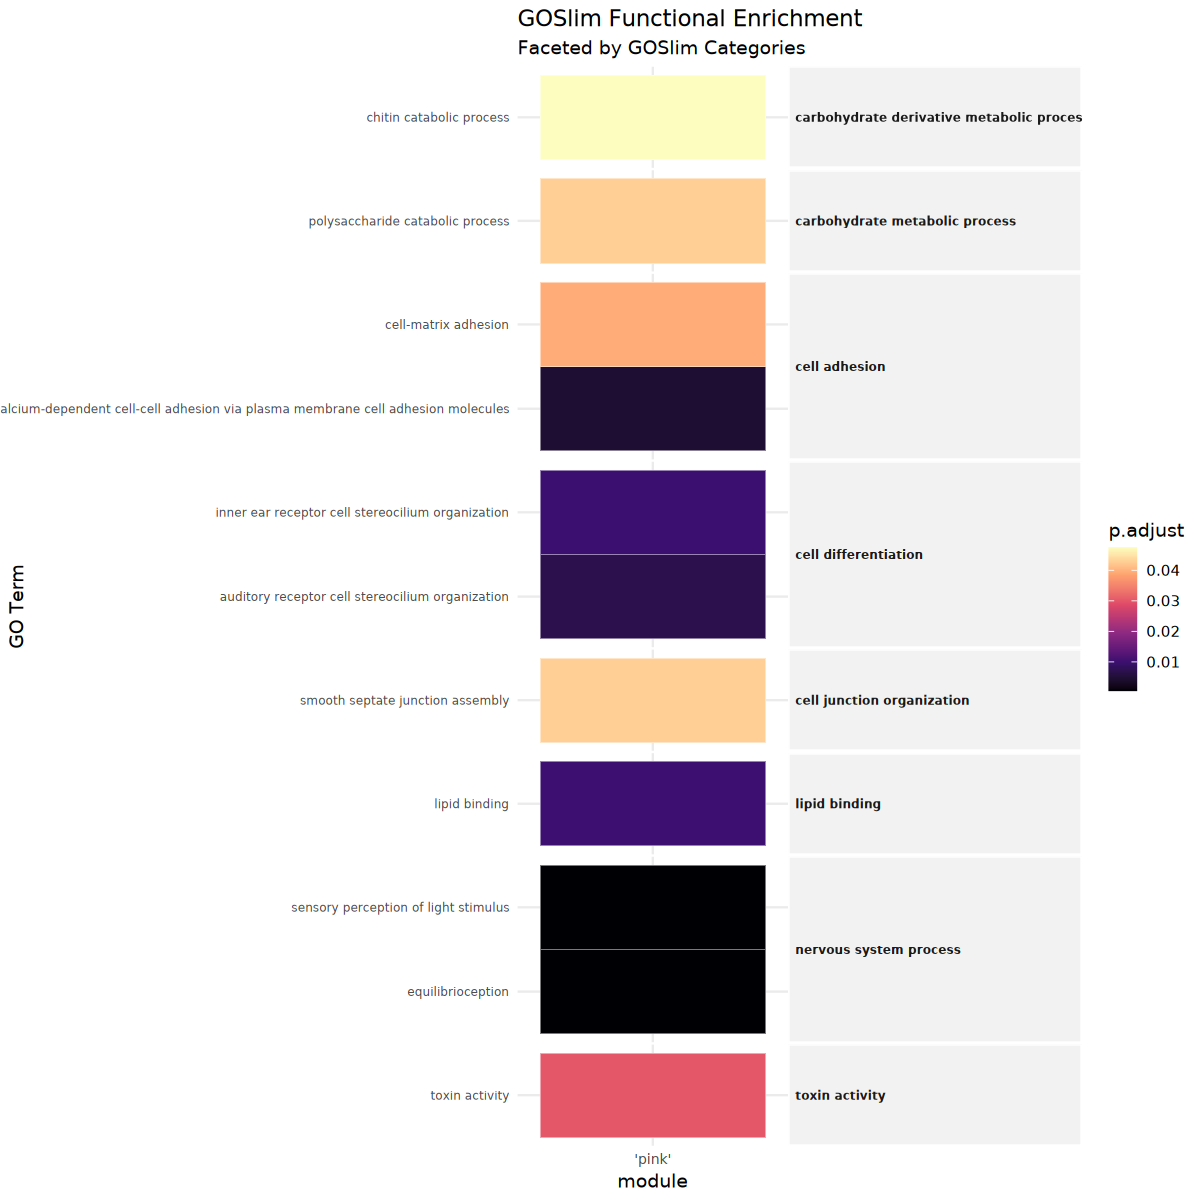

In [26]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(pink_final, aes(x = module, y = Description, fill = p.adjust)) +
  geom_tile(color = "white", size = 0.1) +
  # Grouping by GOSlim Category on the right side
  facet_grid(GOSlim_Bin ~ ., scales = "free_y", space = "free_y") +
  # Use a color scale that makes significant results "pop"
  scale_fill_viridis_c(option = "magma") +
  theme_minimal() +
  theme(
    strip.text.y = element_text(angle = 0, size = 7, face = "bold", hjust = 0),
    strip.background = element_rect(fill = "gray95", color = "white"),
    axis.text.y = element_text(size = 7),
    axis.text.x = element_text(size = 8),
    panel.spacing = unit(0.1, "lines"),
    legend.position = "right"
  ) +
  labs(
    title = "GOSlim Functional Enrichment",
    subtitle = "Faceted by GOSlim Categories",
    y = "GO Term"
  )